In [1]:
import numpy as np
import pandas as pd
import scipy.signal

from scipy import misc
from numpy import linalg as LA

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import avgn_attack
from utils import convolve2D
from utils import (
    forward_differences_second,
    backward_differences,
    forward_differences
    
)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb, [0.2989, 0.5870, 0.1140])

sample = scipy.misc.face(gray=True) / 255

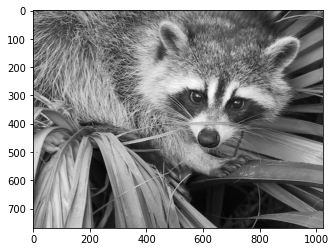

In [33]:
plt.imshow(sample, "gray")
plt.show()

In [48]:
noisy_sample = avgn_attack(sample, std=0.5, mean=0)

image_filter = 1/25.* np.ones([5, 5])

noisy_sample = scipy.signal.convolve2d(noisy_sample, image_filter)

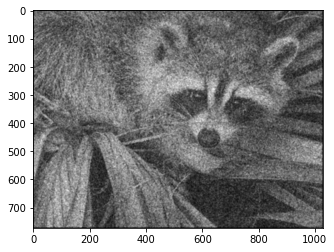

In [49]:
plt.imshow(noisy_sample, "gray")
plt.show()

Let us consider the discrete setting. In the $2 \mathrm{D}$ discrete case, we have images with $N \times M$ pixels. The $(i, j)$ -th entry of the blurry image $u$ will be denoted by $u_{i, j}$. We consider four possible first order (discrete) derivatives of $u$ according to whether forward or backward differences are used:
$$
\nabla_{F F} u \doteq\left[u_{i+1, j}-u_{i, j} \quad u_{i, j+1}-u_{i, j}\right]^{T}
$$
$$
\nabla_{F B} u \doteq\left[u_{i+1, j}-u_{i, j} \quad u_{i, j}-u_{i, j-1}\right]^{T}
$$
$$
\nabla_{B F} u \doteq\left[u_{i, j}-u_{i-1, j} \quad u_{i, j+1}-u_{i, j}\right]^{T}
$$
$$
\nabla_{B B} u \doteq\left[u_{i, j}-u_{i-1, j} \quad u_{i, j}-u_{i, j-1}\right]^{T}
$$

In [50]:
import numpy as np
from scipy import optimize
from scipy import misc

# Original implementation
# https://github.com/danoan/image-processing/blob/master/denoise.py

class TotalGradient:
    def __init__(self, image):
        fd = forward_differences(image)
        self.gradX = fd[0]
        self.gradY = fd[1]

        fd2 = forward_differences_second(image)
        self.grad2X = fd2[0]
        self.grad2Y = fd2[1]

    def norm(self):
        return self.gradX**2 + self.gradY**2

class Tikhonov:
    def __init__(self, image, alpha):
        self.image = image
        self.alpha = alpha

        self.shape = self.image.shape
        self.size = self.image.size

    def jacobian(self, x):
        _x = x.reshape(self.shape)
        TG = TotalGradient(_x)

        S = self.alpha * (TG.grad2X + TG.grad2Y)
        return (_x - self.image - S).reshape(self.size,)

    def tikhonov(self, x):
        _x = x.reshape( self.shape )
        TG = TotalGradient(_x)

        # arg min_x || A(x) - y ||^2 + r(x)
        # r(x) - log prior
        # y - noisy image
        # A(x) - reconstructed image        
        v = 0.5*(LA.norm(_x - self.image)**2 + self.alpha*np.sum(TG.norm()))
        return v

def denoise_image(input_image, alpha, max_it, print_output=False):
    T = Tikhonov(input_image, alpha)
    solution = optimize.minimize(
        lambda x: T.tikhonov(x),
        np.zeros(T.image.size,),
        jac=lambda x: T.jacobian(x),
        method="CG",
        options={
            "maxiter":max_it, 
            "disp":print_output
        }
    )

    x = solution["x"].reshape(T.shape)
    return x

In [57]:
denoised_sample = denoise_image(noisy_sample, 0.5, 100, print_output=True)

# print("Original to denoised norm: ", LA.norm(sample - denoised_sample))
# print("Original to noised norm: ", LA.norm(sample - noisy_sample))

         Current function value: 702.949346
         Iterations: 10
         Function evaluations: 124
         Gradient evaluations: 111


#### Noisy image

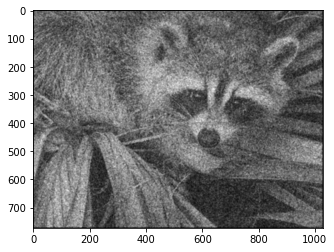

In [58]:
plt.imshow(noisy_sample, 'gray')

#### Denoised image

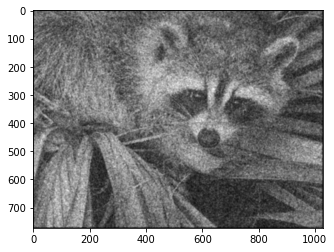

In [59]:
plt.imshow(denoised_sample, 'gray')

### Image filters

In [54]:
# sobol_filter = np.asarray([[-1, 0, 1],
#                            [-2, 0, 2],
#                            [-1, 0, 1]])
sobol_filter = np.asarray([[1, 1, 1],
                           [0, 0, 0],
                           [-1, -1, -1]])



# img_convolved_scipy = scipy.signal.convolve2d(sample, sobol_filter)
# img_convolved_my = convolve2D(sample, sobol_filter, padding=2)
# print(LA.norm(img_convolved_scipy - img_convolved_my))

#### Noisy image

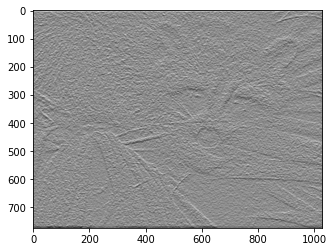

In [55]:
noisy_filter = scipy.signal.convolve2d(noisy_sample, sobol_filter)
plt.imshow(noisy_filter, cmap='gray')

#### Denoised image

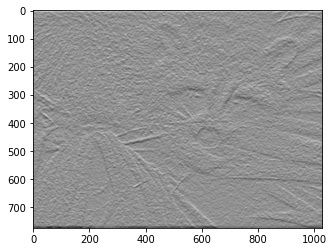

In [56]:
denoised_filter =  scipy.signal.convolve2d(denoised_sample, sobol_filter)
plt.imshow(denoised_filter, cmap='gray')